# Линейная регрессия

Здесь хороший повод поговорить о математике, но меня просили не. Что ж, надеюсь, это не помешает вам сопоставить теорию с практикой. 

Суть: у нас есть несколько параметров и есть некоторое числовое значение, зависимость которого от этих самых параметров мы и хотим узнать. Например: есть количество квартир в доме, есть площадь парковки возле дома и есть площадь конкретной квартиры. По этим трём параметрам нужно найти стоимость этой квартиры. Пара из трёх параметров и цены квартиры составляют одну запись/один индивид. Таких индивидов у нас несколько (желательно довольно много). 

## Цели линейной регрессии

Собственно линейную регрессию используют для двух целей:
* Предсказать значение нового индивида при известных параметрах
* Объяснить как влияет каждый из параметров на искомое значение

## Когда её используют

Обычно её используют для получения первых выводов из данных, перед тем как начать использовать ~~нормальные~~ более сложные модели. 

## Какой у нас план?

В виду ограничений, будем пытаться разобраться по ходу, надеюсь, вам будет понятно. Вообще будет здорово, если освежите теоретические основы, но постараюсь всё показать на живом примере. Очень живом примере. Я постараюсь здесь показать ход размышлений, не влезая при этом глубоко в математику. Мы будем ошибаться. Мы будем *много* ошибаться. **Очень много**. Это не методичка "как сделать хорошо", это разбор конкретного примера, причём это черновик, за единственным исключением $\text{---}$ мы ничего не зачёркиваем. 

## Библиотека 

По традиции, нам нужно для начала установить библиотеку. В нашем случае на выбор предоставляется две библиотеки: `statsmodels` и `scikit-learn` (читают *склёрн*). Первая хороша для тех, кто дружит с матстатом, поэтому это не наш случай и выбираем вторую. Функционал этих библиотек не ограничен исключительно линейной регрессией, но пока мы рассмотрим только её. 

In [ ]:
# !pip install scikit-learn

### Импорт

Внезапно, импортируем мы её не как `import scikit-learn` и даже не `import sklearn`. Библиотека довольно объёмна, а нам нужны только отдельные её модули, даже отдельные части её модулей. Для большей целостности импортируем всё необходимое здесь, а по ходу дела буду объяснять, что именно мы здесь набрали.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

## Начало работы / обработка датасета

### Обзор

Самое первое, что необходимо сделать $\text{---}$ так это узнать какие данные у нас есть и что мы хотим вообще найти. 

> Online property companies offer valuations of houses using machine learning techniques. The aim of this report is to predict the house sales in King County, Washington State, USA using Multiple Linear Regression (MLR). The dataset consisted of historic data of houses sold between May 2014 to May 2015.

В общем, по данным о недвижке будем предсказывать стоимость.

In [34]:
file_name = 'kc_house_data.csv'

df = pd.read_csv(file_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

### Удаление "лишних" признаков

Сразу удалим то, что нам не нужно. 
* `id` $\text{---}$ идентификационный код никак не может повлиять на стоимость квартиры.
* `zipcode` $\text{---}$ это америакнский почтовый индекс, его можно использовать в анализе, но *feature exploration* такого уровня выходит за рамки нашего курса.
* `lat` и `long` $\text{---}$ широта и долгота, та же ситуация, что и выше. 

In [35]:
df.drop(['id', 'zipcode', 'lat', 'long'], axis=1, inplace=True)
df['price'] = df.pop('price') # для красоты поставим в конец
df.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,1340,5650,221900.0
1,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,1690,7639,538000.0
2,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,2720,8062,180000.0
3,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,1360,5000,604000.0
4,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,1800,7503,510000.0


### Модификация

Теперь разберёмся с оставшимися:
* `bedrooms` и `bathrooms` $\text{---}$ соответственно количество спален и ванных комнат. Внезапно количество ванных комнат не обязательно натуральное число, но что с них взять $\text{---}$ у них шоколадные батончики в дюймах и рутбир в пинтах. 
* `sqft_living` и `sqft_lot` $\text{---}$ соответственно площадь жилых помещений и земельных участков. 
* `sqft_living15` и `sqft_lot15` $\text{---}$ соответственно площадь жилых помещений и земельных участков, но в этот раз не конкретной недвижки, а ближайших 15 объектов. 
* `sqft_basement` и `sqft_above` $\text{---}$ соответственно площадь подвальных помещений и надземных. 
* `floors` $\text{---}$ количество этажей, та же история, что и с ванными комнатами.
* `waterfront` $\text{---}$ находится возле набережной.
* `viewfront`, `condition` и `grade` $\text{---}$ те или иные качественные оценки дома и окружающего вида. 
* `date` $\text{---}$ дата продажи дома.

Данные у нас с мая 14-ого по май 15-ого, допустим, что различия между месяцами больше, чем различия внутри месяца, поэтому преобразуем дату в строку вида `MM.YY`, сделаем из этого категориальную переменную. Вообще правильно было бы сделать несколько предположений, попробовать объединить по сезонам, кварталам, полугодиям, но в силу задач нашего курса оставим эту важную работу вам. Можете потом сообщить результаты.  

In [36]:
df['date'] = [f'"{d[4:6]}.{d[2:4]}"' for d in df["date"]]
df.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,"""10.14""",3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,1340,5650,221900.0
1,"""12.14""",3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,1690,7639,538000.0
2,"""02.15""",2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,2720,8062,180000.0
3,"""12.14""",4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,1360,5000,604000.0
4,"""02.15""",3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,1800,7503,510000.0


### Сохранение

Сохраним преобразованные данные, чтобы не проводить вышеописанное каждый раз. В нашем случае не критично, но привычка полезная.

In [ ]:
save_file_name = 'kc_house_data_mod.csv'
df.to_csv(save_file_name, index=False)
df = pd.read_csv(save_file_name)
df['date'] = df['date'].astype('category') # делаем категориальной

### Треин/тест

Далее разделим датасет на обучающий и проверочный набор данных. В проверочный набор данных мы не лезем. Совсем не лезем. Даже не смотрим. Это нечестно. Так делать не надо. 

In [37]:
seed = 3 # зерно для воспроизводимости результатов от случайных ф-ций
train, test = train_test_split(df, train_size=0.8, random_state=seed)

### Анализ фич

Не помню говорил ли, но на всякий случай: фича = признак = независимая переменная.

Вообще, с точки зрения математики, необходимо обратить внимание на следующие признаки: `sqft_living`, `sqft_basement` и `sqft_above`. Дело в том, что они отчасти перекрывают друг друга. Если подвальные помещения оборудованы под жилые, то площадь подвального помещения уже будет учтена в площади жилых помещений. Если подвала нет, то площадь надземных помещений (как мы увидим далее) часто равна площади жилых помещений, тем самым она будет учтена дважды. В некотором смысле мы получаем такое страшное словосочетание как "линейная комбинация", а применяя метод линейной регрессии желательно не иметь в своих данных линейных комбинаций, т.к. есть методы, которые вообще не сойдутся при таких условиях. Мы попытаемся как-то разрешить эту проблему, но предупреждаю сразу, что я не буду пытаться достичь лучшего результата, поскольку, ну, это просто учебный пример. Посмотрим что мы можем вытащить.

In [38]:
# Количество объектов, где сумма площади надземных и подземных помещений не
# равна площади надземных помещений   
train[(train['sqft_above'] + train['sqft_basement']) 
      != train['sqft_living']].shape[0]

2

In [39]:
# Количество объектов, где площадь надземных помещений не равна площади жилых 
# помещений, при отсутствующем подвале (очевидно, что это один из тех двух
# случаев).
len(train[(train['sqft_above'] != train['sqft_living']) 
          & (train['sqft_basement'] == 0)])

1

#### Ой...

И если вы не сказали сейчас: "Так, минуточку", то это было зря. Можете сказать это сейчас, а я объясню почему. Вернёмся к выводу информации о датасете. Я дублировать не буду, сами посмотрите. Если присмотреться внимательно к выводу информации о датафрейме то можно заметить, что у нас есть целых два пропущенных значения в площади надземных помещений. Проверим это. 

In [40]:
train.isna().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

По *счастливому совпадению* (не забывайте, что у нас учебный проект) все пропущенные значения оказались в нашей обучающей выборке. Если бы пропущенные значения оказались бы в тестовом наборе данных, то нужно было бы придумать метод заполнения данных исходя только из обучающего набора данных и применять из вслепую на тестовом наборе данных.

Самые примитивные методы устранения пропущенных значений мы рассматривали в главе про Pandas, но сейчас нам не нужны ни примитивные, ни сложные методы. Мы поступим довольно логично и устраним пропуски следующим способом. Обратим внимание, что сумма площадей надземных и подземных помещений не равна площади жилых помещений только в двух случаях, а именно когда площадь надземных помещений неизвестна (поскольку неизвестное + известное = неизвестное). Сейчас мы это продемонстрируем для тех, кто не верит.

In [41]:
missing_rows = train[train['sqft_above'].isna()]
print(missing_rows, '\n')

print(missing_rows['sqft_above'] + missing_rows['sqft_basement'])

       date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
17  "05.14"         4        1.0         1600      4300     1.5           0   
10  "04.15"         3        2.5         3560      9796     1.0           0   

    view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
17     0          4      7         NaN              0      1916             0   
10     0          3      8         NaN           1700      1965             0   

    sqft_living15  sqft_lot15     price  
17           1610        4300  485000.0  
10           2210        8925  662500.0   

17   NaN
10   NaN
dtype: float64


Так вот, исходя из вышесказанного, приравняем площади надземных помещений разницу между площадями жилых и подземных помещений. Кстати, текст никто не вычитывает, а я довольно часто могу оставить неверное склонение слов из-за того, что в голове уже 10 раз изменил формулировку предложения, так что приношу свои извинения, если ваши глаза к этому моменту уже вытекли. Ну или как говорится: "А сердечник для двигателя я сделаю из дерева, потому что до этого момента, ясень пень, никто не дочитает". А мы двигаемся дальше.

#### Модификация

In [42]:
mask = train['sqft_above'].isna()
train.loc[mask, 'sqft_above'] = train.loc[mask, 'sqft_living'] \
                                - train.loc[mask, 'sqft_basement']
train.isna().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

Ну красота же? Вообще говоря не обязательно было выделять маску (если забыл $\text{---}$ беги перечитывать про булеву индексацию), поскольку векторизация, оптимизация, C, ну вы поняли короче, всё равно нормально работало бы, тем более, что у нас не гигатоны данных, это первое. А второе, что мы должны были бы проделать то же самое и с тестовым датасетом, но поскольку по *счастливой случайности* все пропущенные значения оказались в трейне (обучающей части), то это крайне важное дело я предоставлю вам. Как сделаете, так возвращайтесь.

In [12]:
# здесь мог быть быть ваш код

#### Удаление

А теперь мы вернулись к тому, с чего начали, что у нас, теперь уже всегда, площадь живых помещений равна сумме площадей надземных и подземных, то есть всё же выходит линейная комбинация признаков, а нам такое не надо. Удалим признак площади жилых помещений. Он нам, правда, понадобится в нестоль отдалённом будущем, но это уже совершенно другая история. 

In [43]:
train.drop('sqft_living', axis=1, inplace=True)
# не забываем повторить на тесте
test.drop('sqft_living', axis=1, inplace=True) 

#### Сохранение 2

Формат csv, конечно, хороший, но для работы иногда удобнее хранить и в других форматах. Например, в pickle, который сохраняет объект (датафрейм) целиком, а не только сырые данные.

Важно, .pkl потенциально опасны и поэтому не стоит загружать данные из чужих файлов, используйте их только для хранения своих файлов, а для обмена используйте другой (чтобы не вызывать лишних подозрений). Просто чтобы следовать своей же рекомендации я не буду заливать свои pkl файлы на гит (хоть они и безопасны). [Ссылка на документацию](https://docs.python.org/3/library/pickle.html#module-pickle) для любопытствующих. 

In [15]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')

Загрузить датафрейм обратно также просто:

In [17]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

## Визуализация

Что ж, нам есть ещё где работать с датасетом (и работы довольно много), но пока остановимся на достигнутом. Посмотрим, что мы имеем сейчас.

### Описательная статистика

In [44]:
train.head()

,date,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
14084,"""05.14""",3,2.00,43560,1.0,0,0,3,7,1510.0,0,1954,0,2060,67756,450000.0
13750,"""04.15""",3,2.50,106722,1.0,0,4,3,9,1970.0,0,1985,0,2910,101494,599950.0
619,"""06.14""",3,2.00,7210,1.0,0,0,3,8,1440.0,0,1983,0,1700,7245,210000.0
18985,"""03.15""",3,1.00,5100,1.0,0,0,3,7,860.0,140,1946,0,1000,5100,425000.0
21382,"""08.14""",4,2.75,7001,2.0,0,0,3,8,2620.0,0,2012,0,2620,6543,499990.0


Мы объясним позже, почему мы не включили в описательную статистику некоторые признаки. Впрочем, может догадаться и сами.

In [86]:
excluded_features = {'yr_built', 'yr_renovated', 'waterfront', 'view', 
                     'condition', 'grade', 'floors', 'bedrooms',
                     'bathrooms', 'date'}
features = list(set(train.columns) - excluded_features)

train[features].describe()

,sqft_living15,sqft_above,sqft_lot15,sqft_lot,price,sqft_basement
count,17290.000000,17290.000000,17290.000000,1.729000e+04,1.729000e+04,17290.000000
mean,1988.341816,1791.674147,12748.963216,1.511332e+04,5.401742e+05,289.518392
std,683.715616,827.836524,26882.821891,4.155453e+04,3.693076e+05,441.986572
min,399.000000,290.000000,651.000000,5.200000e+02,8.100000e+04,0.000000
25%,1490.000000,1200.000000,5100.000000,5.040000e+03,3.224250e+05,0.000000
50%,1840.000000,1570.000000,7620.000000,7.611500e+03,4.500000e+05,0.000000
75%,2360.000000,2220.000000,10080.000000,1.071600e+04,6.448750e+05,560.000000
max,6210.000000,9410.000000,858132.000000,1.651359e+06,7.700000e+06,4820.000000


### Ящики с усами и столбчатые диаграммы

#### Качественные переменные

Сейчас будет очень много графиков, смотрите на них внимательно, объяснение будет после котика (он для привлечения внимания).

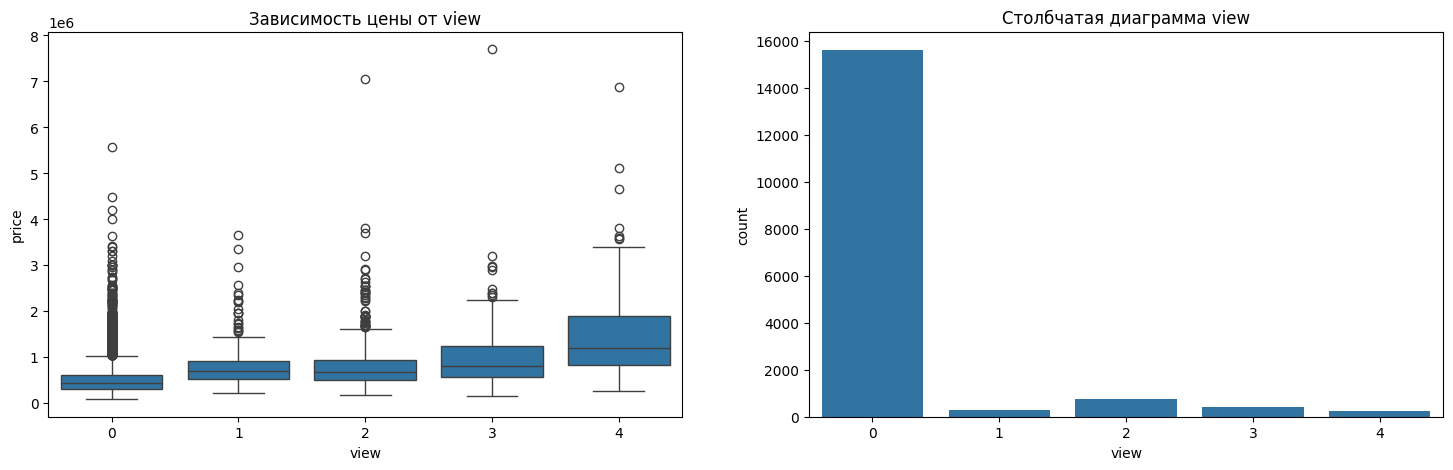

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='view', y='price', data=train, ax=axes[0])
sns.countplot(x='view', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от view')
axes[1].set_title('Столбчатая диаграмма view')
axes[0].set_xlabel('view')
axes[1].set_xlabel('view')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

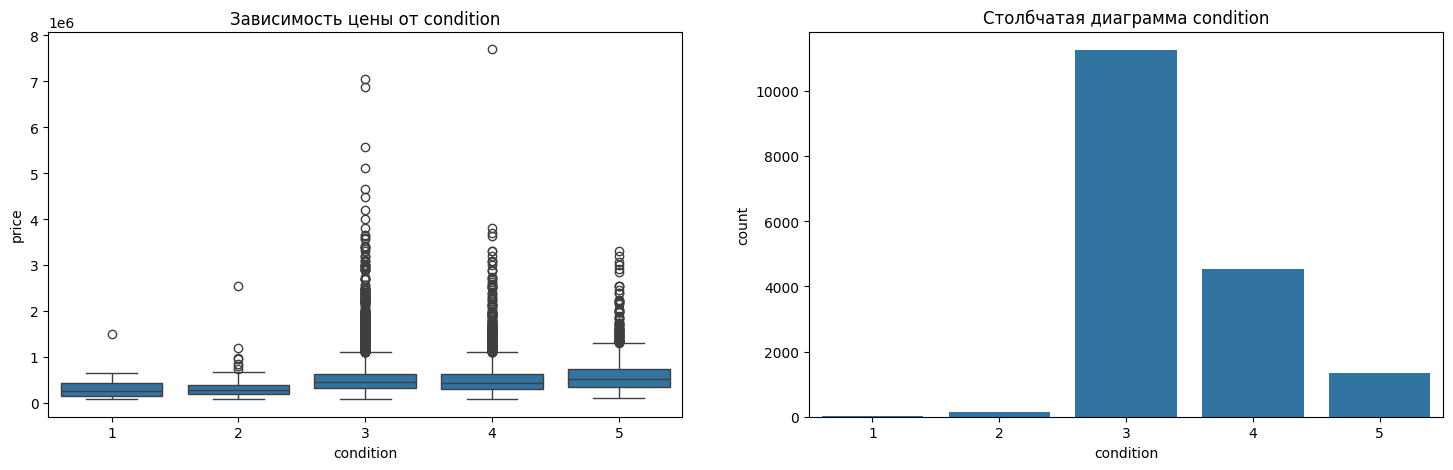

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='condition', y='price', data=train, ax=axes[0])
sns.countplot(x='condition', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от condition')
axes[1].set_title('Столбчатая диаграмма condition')
axes[0].set_xlabel('condition')
axes[1].set_xlabel('condition')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

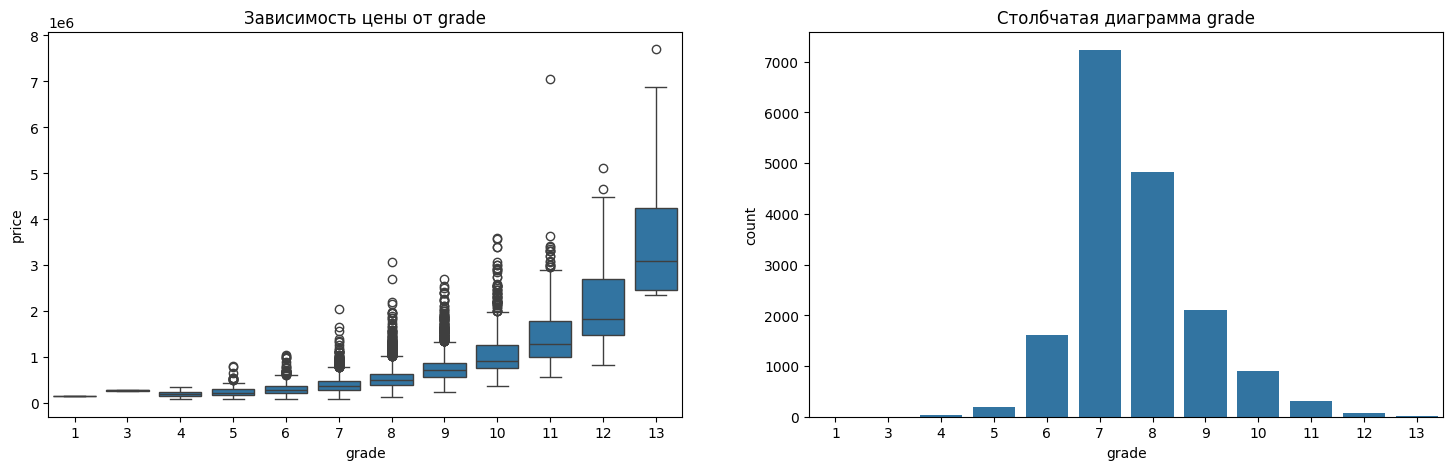

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='grade', y='price', data=train, ax=axes[0])
sns.countplot(x='grade', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от grade')
axes[1].set_title('Столбчатая диаграмма grade')
axes[0].set_xlabel('grade')
axes[1].set_xlabel('grade')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

In [17]:
set(train['grade'])

{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

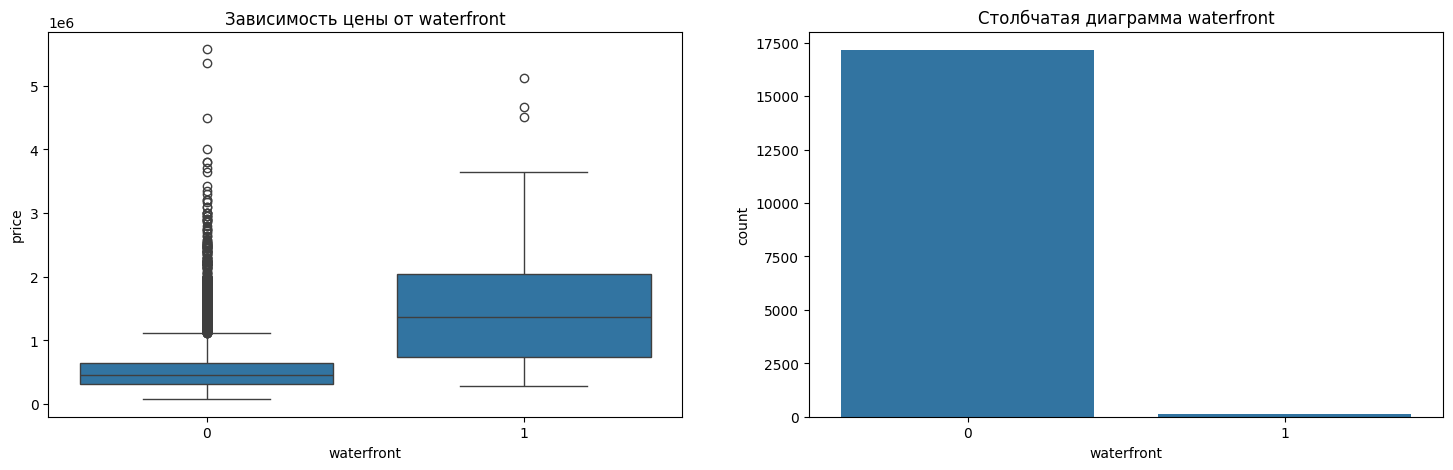

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='waterfront', y='price', data=train, ax=axes[0])
sns.countplot(x='waterfront', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от waterfront')
axes[1].set_title('Столбчатая диаграмма waterfront')
axes[0].set_xlabel('waterfront')
axes[1].set_xlabel('waterfront')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

#### Дискретные переменные

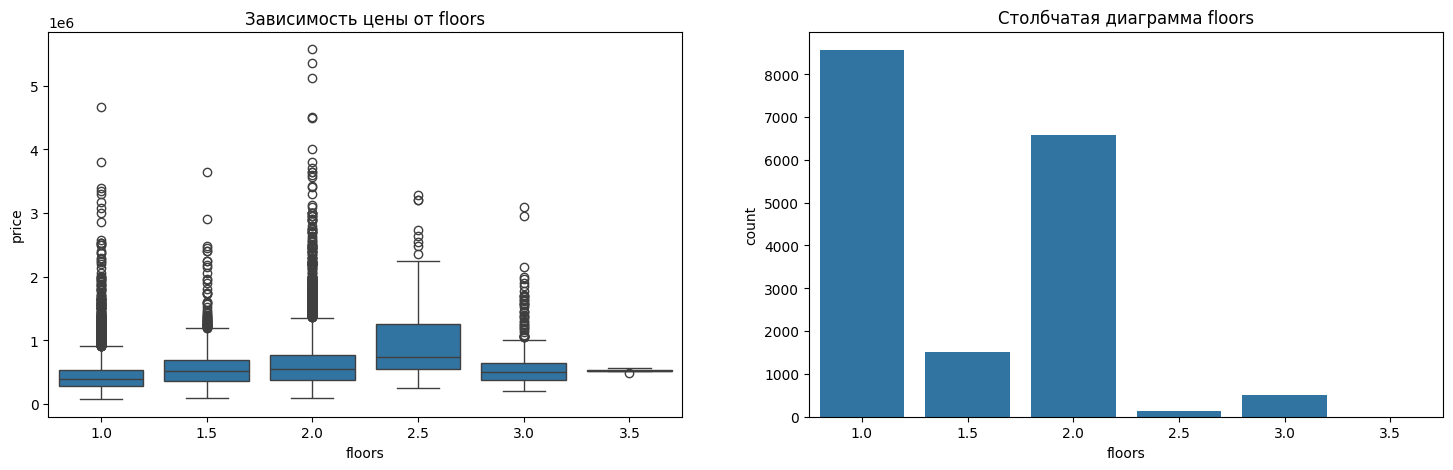

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='floors', y='price', data=train, ax=axes[0])
sns.countplot(x='floors', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от floors')
axes[1].set_title('Столбчатая диаграмма floors')
axes[0].set_xlabel('floors')
axes[1].set_xlabel('floors')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

C:\Users\ShkuratD\AppData\Local\Temp\ipykernel_12472\218583.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


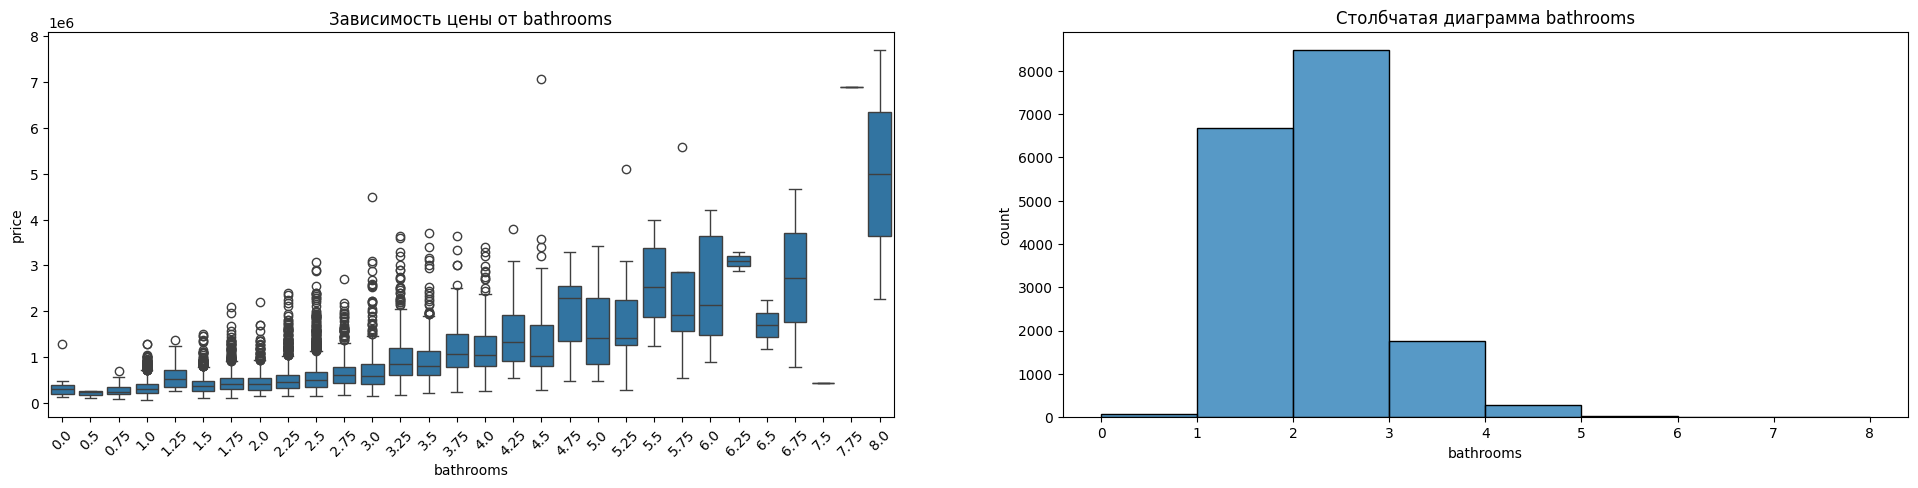

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
sns.boxplot(x='bathrooms', y='price', data=train, ax=axes[0])
sns.histplot(x='bathrooms', data=train, ax=axes[1], bins=8)
axes[0].set_title('Зависимость цены от bathrooms')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[1].set_title('Столбчатая диаграмма bathrooms')
axes[0].set_xlabel('bathrooms')
axes[1].set_xlabel('bathrooms')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

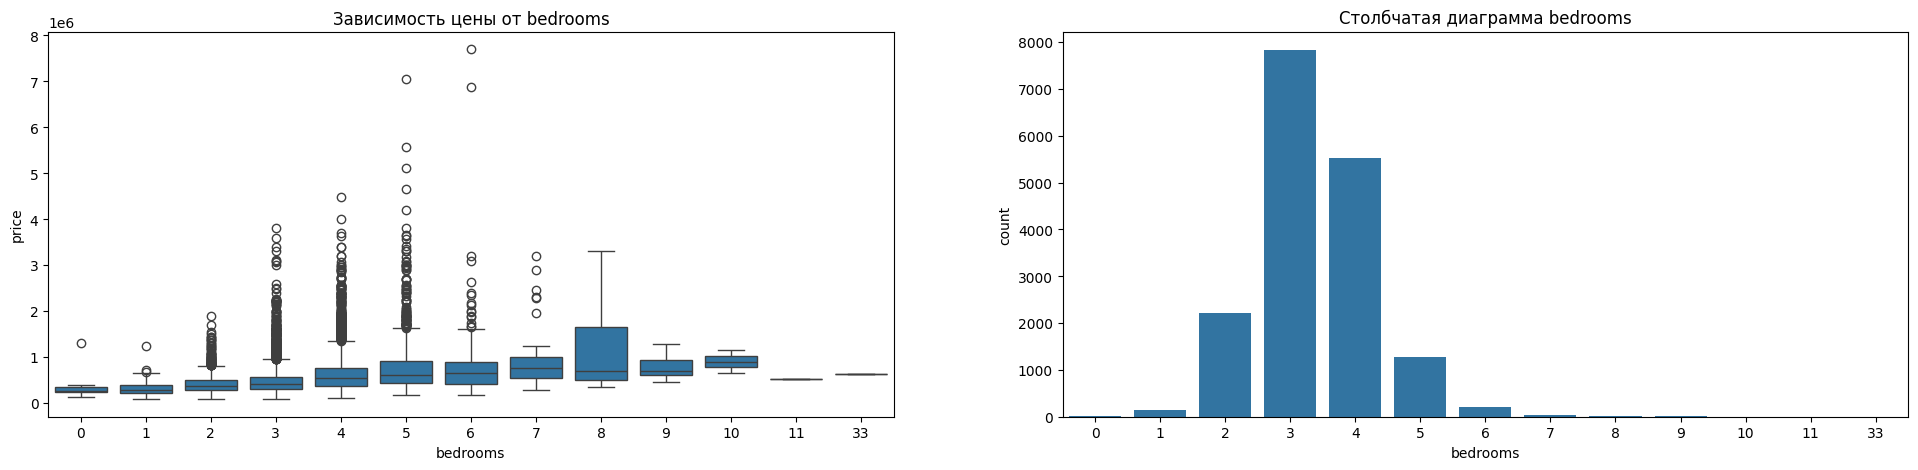

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
sns.boxplot(x='bedrooms', y='price', data=train, ax=axes[0])
sns.countplot(x='bedrooms', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от bedrooms')
axes[1].set_title('Столбчатая диаграмма bedrooms')
axes[0].set_xlabel('bedrooms')
axes[1].set_xlabel('bedrooms')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

![image](warning.png)

Теперь проанализируем что вышло:
* Качественные
    * Чем лучше вид (`view`), тем больше и цена. Увеличивающийся разброс с ростом качества вида возможно объясняется тем, что объектов с "хоть каким-то" видом много меньше, чем объектов без вида вообще. Вместе с тем наблюдаем, что у объектов без вида действительно низкая цена, небольшой, стабильный разброс (при таком-то количестве), но очень много выбросов. Наличие большого количества выбросов указывает, что вид это не единственный существенный фактоор, определяющий цену.
    * Состояние (`condition`) не сильно влияет на цену, при этом домов в состоянии "ниже среднего" очень мало, а у остальных $\text{---}$ примерно одинаковый разброс и медиана, а также много выбросов. Можно предположить, что состояние не это самый важный фактор образования цены (да, мы повтороли то, с чего начали, но теперь немного более аргументировано, чем просто "похоже, что все ящики с усами на одном уровне"). Стоит учесть, что "$4$" и "$5$" также меньше, чем "$3$", что может повлиять на разброс и положение в соответствующих категориях.
    * С ростом `grade` (оценки дома в целом?) цена растёт значительно. При этом распределение оценок похоже на нормальное (но его нельзя назвать таковым, только похожим) и количество объектов в хвостах значительно меньше, чем объектов по центру; этим (хвостами) и объясняется большая дисперсия у лучших домов. Поскольку рост цены очевиден, то можем заключить, что это важный фактор, влияющий на цену. 
    * Дома возле набережной (`waterfront`) стоят значительно больше, но при этом их немного (что тоже влияет на цену, кстати) и поэтому у них нестабильная дисперсия.
* Дискретные
    * С этажами (`floors`) дело обстоит непросто. Во-первых, данные снова неравномерны. Одноэтоэтажных и двухэтажных домов много больше остальных. Во-вторых, $2.5$-$3.5$ этажных домов совсем мало и мы наблюдаем некоторый спад цены. Хотя у трёхэтажных домов вроде довольно стабильная дисперсия, иначе не было бы той кучи выбросов, что мы наблюдаем. Конечно, для большей уверенности лучше было бы посчитать, но для наших задач подойдёт и только визуальный анализ (во всяком случае пока). В целом, по количеству выбросов и по расположению ящиков с усами, можно сделать вывод, что количество этажей влияет на стоимость, но а) нелинейно (до $2.5$ этажей растёт, дальше падает) и б) точно не входит в топ самых важных факторов.
    * При анализе влияния количества ванных (`bathrooms`) очень важно иметь под рукой глазные капли, потому что без боли на эти графики не взглянешь. Начнём с того, что тут очень странная градация количества ванных комнат и идут они четвертями, но мы уже это обсуждали (а может это было дальше, не помню уже). Больше всего у нас от одной до трёх ваннных комнат. Вроде бы с увеличением количества растёт и цена, но из-за недостаточного количества данных и разброс получается огромным (если он вообще там будет, у $7.75$ его совсем не видно). В границах $1$-$3$ мы видим большое количество выбросов, снова говорящих о том, что это не определяющий фактор. Кажется, что этот фактор лучше учитывать как численный, чем как категориальный.
    * Последнее $\text{---}$ количество спален (`bedrooms`). Тоже относительно проблемная вещь. Вроде бы цена растёт с увеличением количества спален, но опять же, начиная с $6$ у нас всё меньше и меньше объектов, а между $11$ и $33$ у нас вообще огромный пропуск и нет никаких данных, так что разумно воспринимать $33$ спальни как выброс. 

### Корреляции

Кстати, графики (и не только) можно спрятать, если ткнуть на синую штуку слева (она будет синей, если ячейка в фокусе, иначе серой или её не будет вообще). Если что, то я знаю, что размер графиков можно настраивать, но мне удобнее, когда они большие, а когда они мне не нужны я их скрываю.

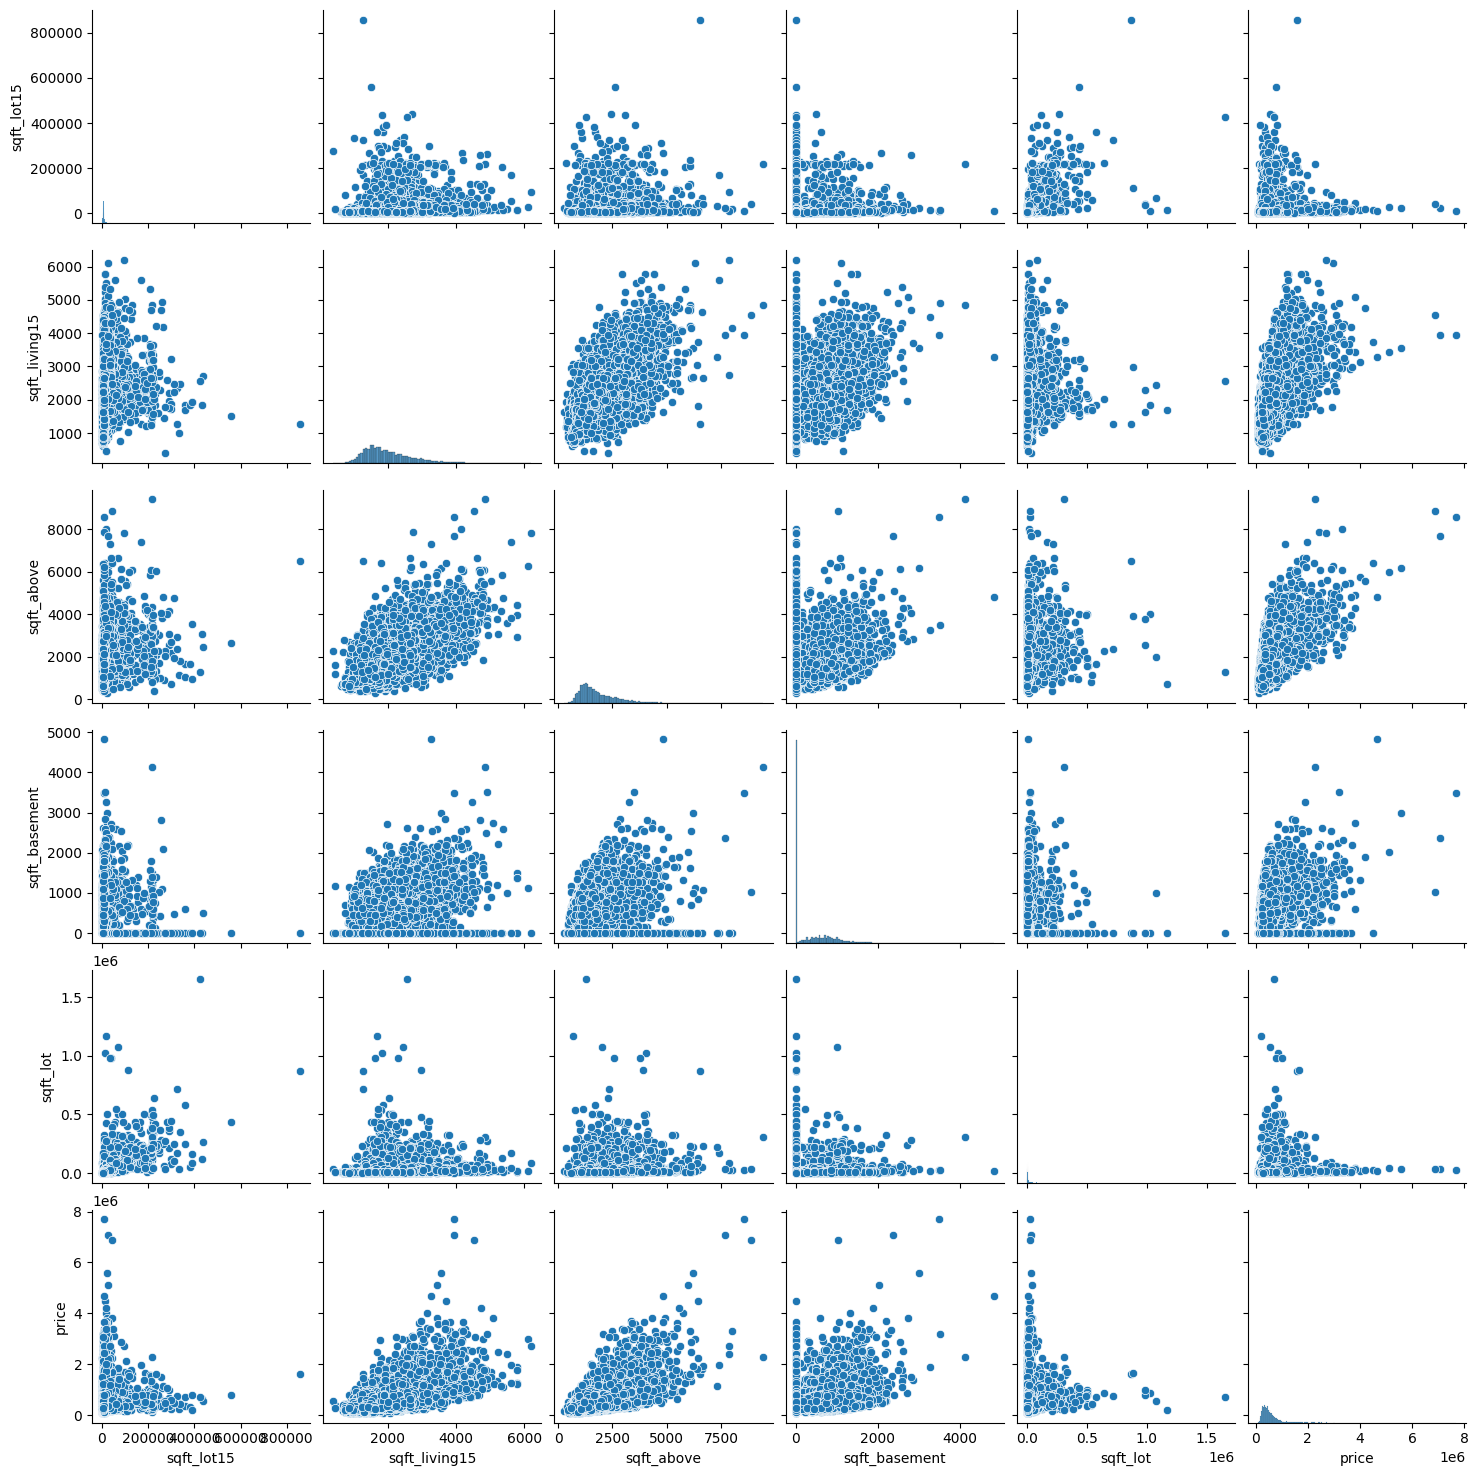

In [36]:
sns.pairplot(train[features])
plt.show()

Также построим корреляционную матрицу.

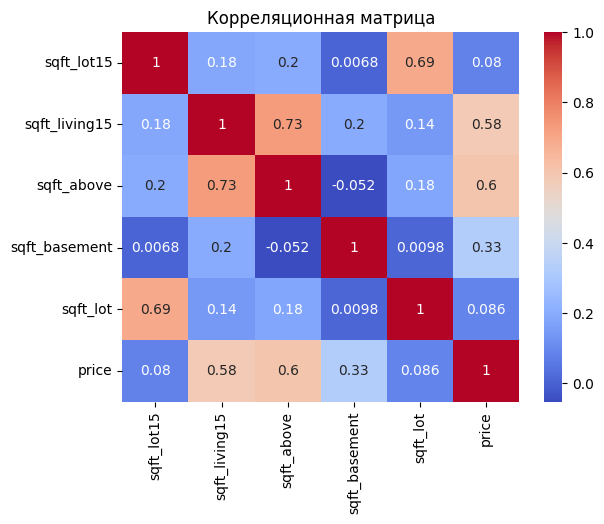

In [37]:
corr = train[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Из pairplot'а и корреляционной матрицы мы видим, что мы немного поторопились с удалением площади жилых помещений, но я уже об этом говорил. Не страшно, восстановить всегда сможем, а удалить обратно можем забыть. Так что временно восстанавливаем и смотрим новые корреляции.

In [38]:
sqft_living = train['sqft_above'] + train['sqft_basement']
# [0, 1] -- т.к. возвращает 2x2 матрицу, нам нужна не главная диагональ
liv_price = np.corrcoef(sqft_living, train['price'])[0, 1] 
liv_liv15 = np.corrcoef(sqft_living, train['sqft_living15'])[0, 1]

print(f'Корреляция между площадью жилых помещений и ценой: {liv_price}')
print('Корреляция между площадью жилых помещений и ей же у соседей: '
      f'{liv_liv15}')

Корреляция между площадью жилых помещений и ценой: 0.7014521705283425
Корреляция между площадью жилых помещений и ей же у соседей: 0.7546666364859265


Как видите корреляция суммы оказалась больше, чем было на корреляционной матрице, но это нормально, это не означает, что мы зря удалили общий признак. Корреляционная матрица нам нужна в первую очередь для того, как сильно будет влиять тот или иной признак на зависимую переменную (капитан очевидность, да), а уже потом даёт повод задуматься а нужен ли нам в анализе та или иная фича (но мы не принимаем решение исходя только из показаний матрицы).

### Скаттерплоты

Теперь ради удовольствия построим несколько скаттерпотов. Gthds

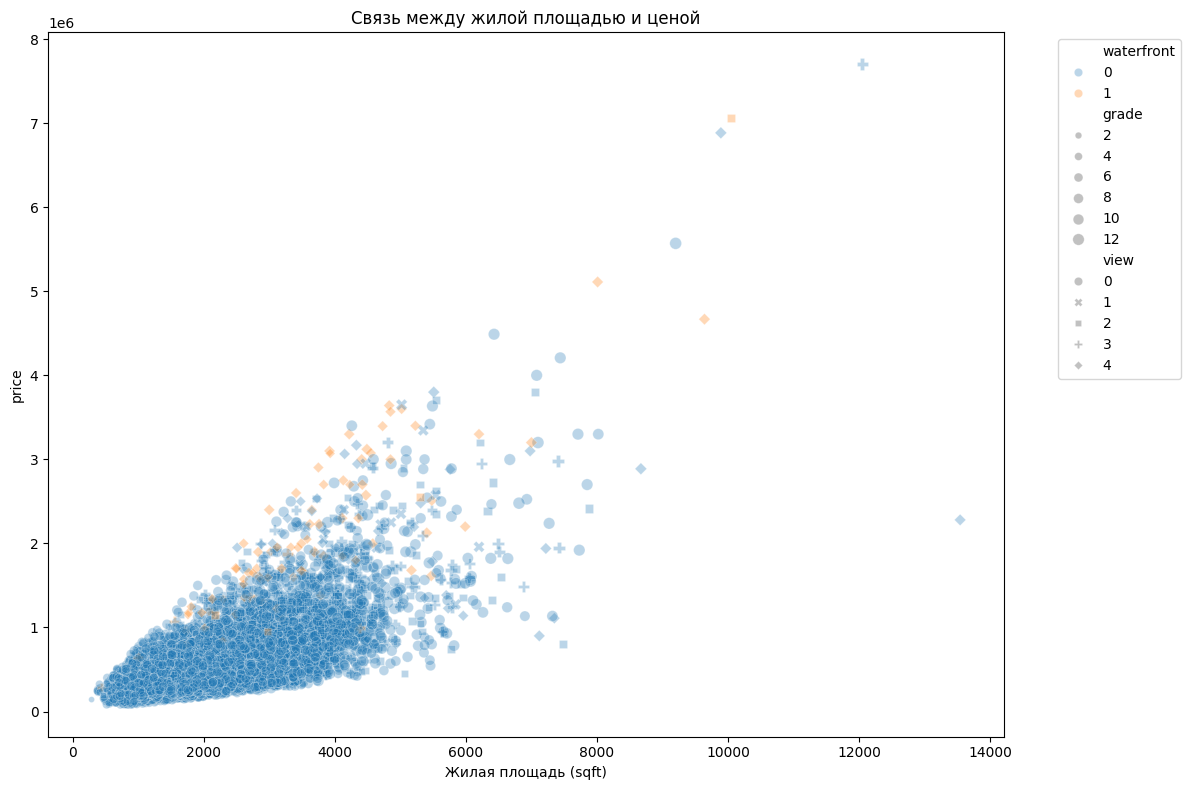

In [44]:
_ = plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x=sqft_living, y='price', hue='waterfront',
                size='grade', style='view', alpha=0.3)
plt.title('Связь между жилой площадью и ценой')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Жилая площадь (sqft)")
plt.tight_layout()
plt.show()

Диаграмма вышла довольно мелкой, мы это исправим, но несколько вещей можно предположить уже отсюда:
1. Домов, где больше восьми тысяч квадратных футов довольно мало, при этом самый большой дом стоит не так уж и много, если сравнивать его с предпоследними. 
1. Это лучше проверить с помощью подсчётов, но дома у набережной имеют лучший вид, что довольно логично. Логично подметить и то, что дома не у набережной тоже могут иметь хороший вид. 

Если выделить дома с площадью меньше 8К футов$^2$ и ценой меньше 2.5 ляма, то мы ничего интересного не увидим. Но вы всё равно сделайте это.

In [49]:
# здесь мог быть ваш код

Также можно построить ~~диаграмму рассеяния~~ скаттерплот, где с помощью разных настроек (как в прошлом графике) продемонстрировать количество спален, ванных комнат и этажей. Мы этого делать не будем. Вернее, я не буду, а вы сделайте.

In [53]:
# здесь мог быть ваш код

Давайте посмотрим на связь стоимости от площади жилых помещений, сгруппировав по виду и нахождении возле(?) набережной.

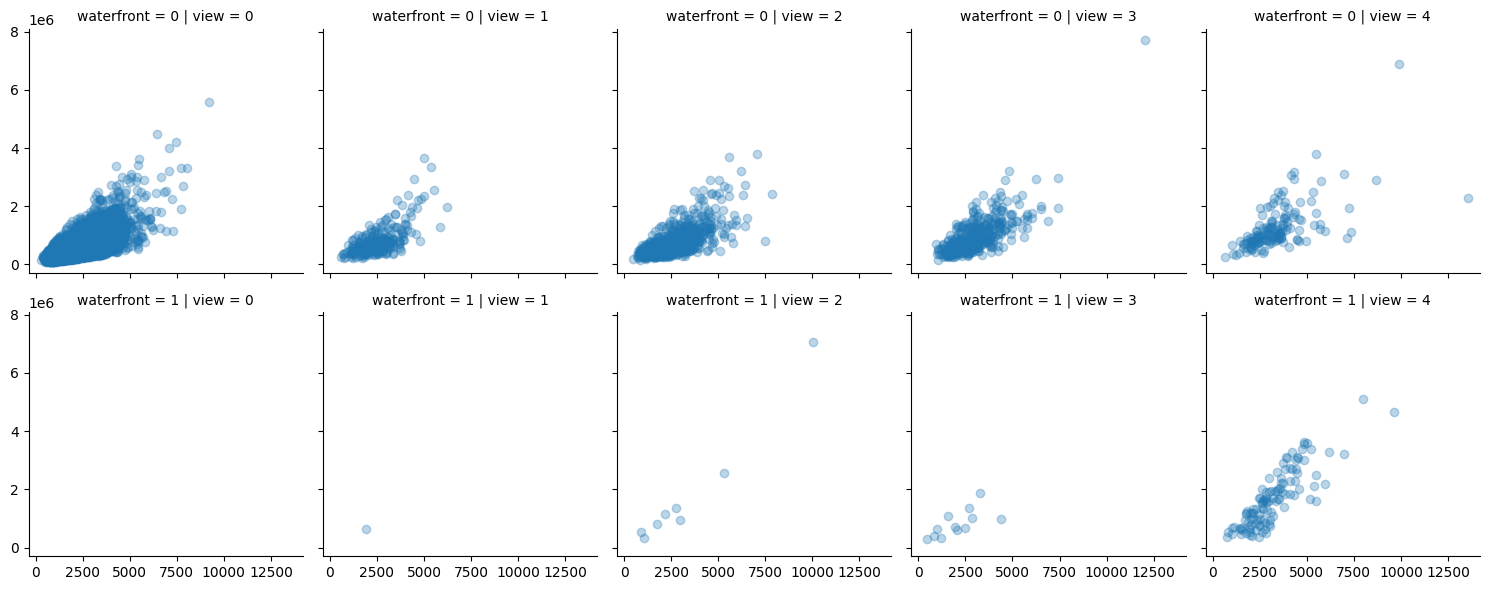

In [61]:
g = sns.FacetGrid(train, col='view', row='waterfront')
# мы не можем передать сюда sqft_living, а восстанавливать столбец я не
# хочу, поэтому немного криво код смотрится
g.map_dataframe(lambda data, color: plt.scatter(
    data['sqft_above'] + data['sqft_basement'], data['price'], 
    color=color, alpha=0.3
))
plt.show()

Как видим, что если дом находится возле набережной, то скорее всего у него и `view` будет хороший, в то время как у домов не возле набережной наоборот, `view` будет скорее меньшим (посмотрите насколько плотно заполнен график при `view=0` и сравните его с `view=4`). Визуально наблюдаем, что в случае с наберженой линия регрессии образует больший угол с осью `x` с улучшением `view`, но не забываем, что данных у нас не так много. В случае "безнабережности" такое сказать сложно, да и вообще напоминаю, что визуальные средства нужны только для оценки и появления первых гипотез. 

### Гистограммы

Построим гистограммы заново, поскольку на pairplot'е их практически не видно.

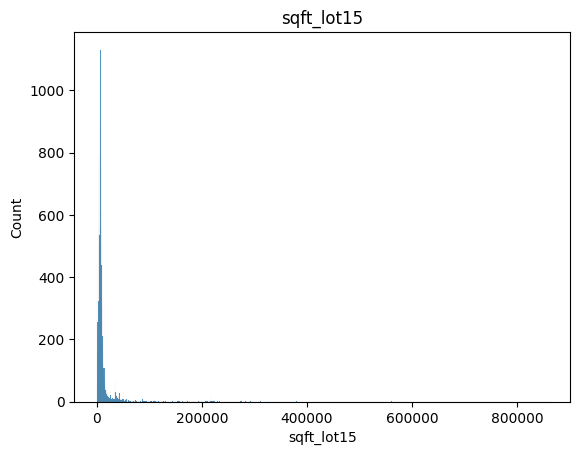

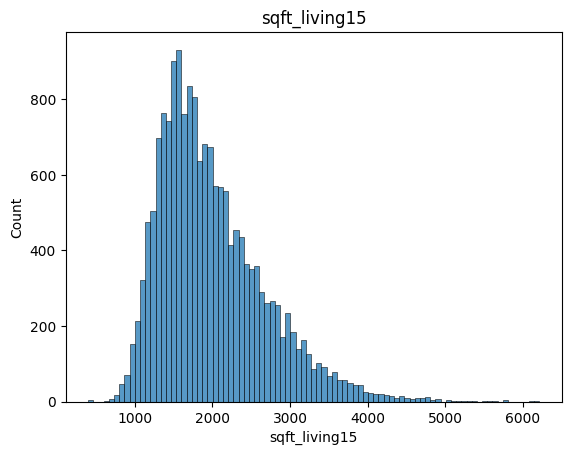

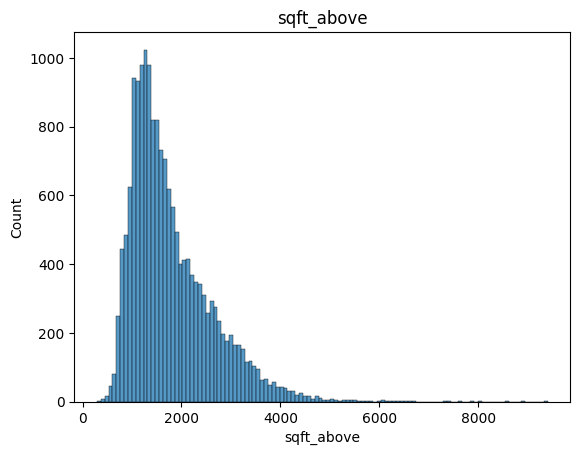

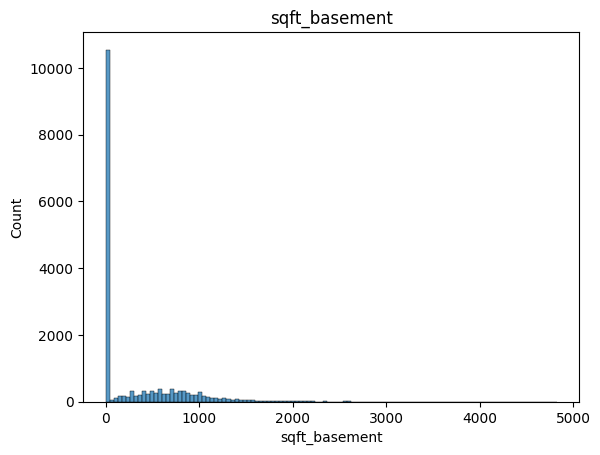

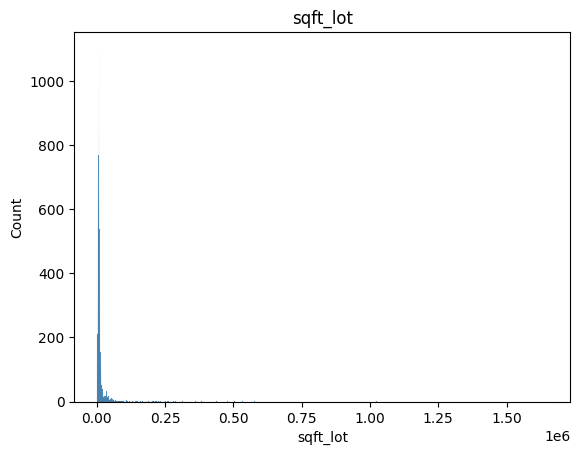

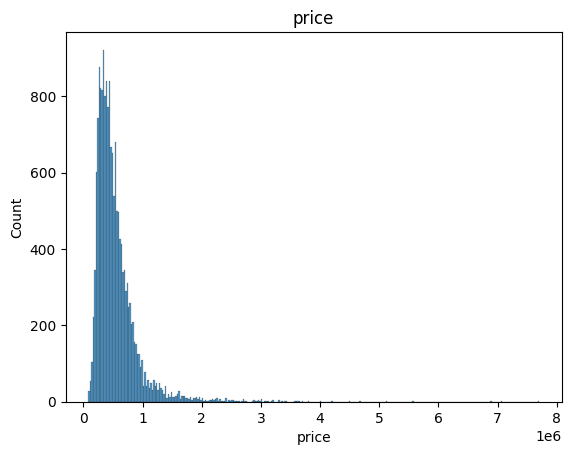

In [62]:
for f in features:
    plt.title(f)
    sns.histplot(train, x=f)
    plt.show()

Посмотрим на `sqft_basement`, где этот самый basement, собственно, есть (поскольку у большинства его нет и гистограмма становится нечитабельной). 

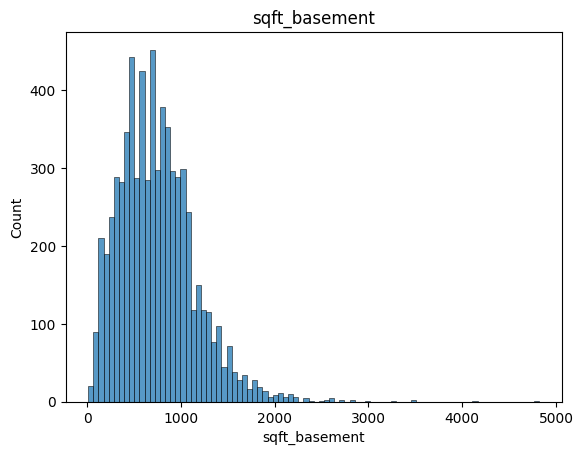

In [63]:
plt.title('sqft_basement')
sns.histplot(train[train['sqft_basement'] > 0], x='sqft_basement')
plt.show()

Как мы видим из гистограмм $\text{---}$ у нас очень длинный правый хвост. Ну, штука, которая понизу стелется справой стороны $\text{---}$ называется правым хвостом, слева $\text{---}$ левый. Это плохо, что он длинный. Если был бы длинный левый хвост, то это тоже плохо, они должны быть примерно одинаковы, ну, знаете, как в нормальном распределении. Это желательно. 

А ещё из функции `describe` мы увидели, что есть огромная разница между третим и четвёртым (т.е. максимумом) квартилем, какой нет между вторым и третьим. Это всё приводит нас к мысли, что в нашем датасете есть выбросы. Мысль хорошая и верная, но сейчас мы сделаем рекламную паузу. 

## Первая попытка

Добро пожаловать на открытый урок онлайн-школы Лоу-скиллз. Сегодня мы докажем вам, что машинное обучение $\text{---}$ это очень просто. После прохождения нашего курса вы сможете создать свой искусственный интеллект и заработать кучу денег. 

Рассмотрим самый просто метод МО $\text{---}$ линейную регрессию. У нас есть данные: их нужно разбить на обучающую и проверочную выборку.

In [64]:
t_train, t_test = train_test_split(train, test_size=0.2, 
                                   random_state=seed) # seed не забываем

В наших данных есть строковая переменная, она нам не нужна, удалим её.

In [65]:
t_train.drop('date', axis=1, inplace=True)
t_test.drop('date', axis=1, inplace=True)

Отделим фичи от цели (независимые переменные от зависимой).

In [66]:
y_t_train = t_train['price'] # выделяем зависимую переменную 
y_t_test = t_test['price']   # на трейн и тесте

X_t_train = t_train.drop('price', axis=1) # убираем её среди независимых
X_t_test = t_test.drop('price', axis=1)   # на трейн и тесте

Теперь создаём нашу модель линейной регрессии и обучаем её!

In [67]:
model = LinearRegression() # создали
model.fit(X_t_train, y_t_train) # обучили
pass

Предсказываем на тесте!

In [68]:
y_t_pred = model.predict(X_t_test)

Теперь посмотрим на результаты!

In [69]:
rmse = np.sqrt(mean_squared_error(y_t_test, y_t_pred))
r2 = r2_score(y_t_test, y_t_pred)
print("\nОценка модели:")
print("RMSE:", rmse)
print("R²:", r2)


Оценка модели:
RMSE: 216140.69543143857
R²: 0.6499178070108185


$R^2$ нашей модели около $0.65$, а значит мы сделали неплохую модель. Приходите к нам и сможете сделать ещё лучше! 

## Рефлексия / Первая адекватная попытка

Я завидую тем, кто поставил адблок. Так вот, как мы только что увидели "обучение модели" $\text{---}$ это самая **скучная** часть нашей работы. Бóльшая часть "нашей" работы это возня с данными и никакого праздника. 

То, что ~~мы~~ они в прошлой попытке выкинули дату на мороз, это, конечно, хорошо, но ~~мы~~ они это сделали только потому что иначе бы модель вообще не обучилась бы. Теперь же сделаем по-нормальному и подробнее прокомментируем что мы вообще делаем. Для начала выберем только непрерывные признаки, а дальше будем усложнять.

Прежде всего мы занимаемся исследованием данных. Это мы уже сделали, но, если бы это был не учебный проект, то впереди было бы ещё куча работы. Просто для вас я покажу постепенные изменения и эта куча нам ещё предстоит, она никуда не денется. 

Дальше скалирование (масштабирование) и удаление выбросов. Про удаление выбросов можно вообще отдельное занятие писать, а то и не одно, поскольку что считать выбросом, что не считать, а если это не выброс, а экстремальное значение, а что если то, а что если сё $\text{---}$ мы поступим рабоче-кресьянским способом, по $|z|$-статистике. Это распространённый метод, но его, как и любые другие методы, стоит использовать с пониманием, но что да как уже за рамками нашего курса. 

### Скалирование / Масштабирование / Скейлинг

Скалирование $\text{---}$ это важно. Результаты предсказания линейной регресии от скалирования не меняются, но она необходима, чтобы привести разные масштабы к какой-то единой системе. Грубо говоря, у вас атомный пароход, который плывёт от Крыма на Гавайи, как сильно изменится скорость если прибавить/отнять пару километров пути или изменить на несколько грамм урана для реактора, вот как понять что важнее километры или топливо? Для этого и производят скалирование. Я, кстати, не знаю как работают атомные параходы, да мне и безразлично в общем-то.

Скалирования бывают разные, самые популярные: мин-макс от $0$ до $1$ и стандартное (должны были проходить в теории). Для линейной регрессии используйте второе. Просто поверьте, примите за эмпирическое правило.

А ещё не совсем корректно называть проверочный датасет тестовым (поскольку тестовый у нас отложен заранее), поэтому назовём его валидационным.

In [ ]:
# во избежание дублирования кода напишем вспомогательную функцию
def our_split(df, features):
    X = df[features].drop('price', axis=1).copy() 
    y = df['price'].copy()
    
    return train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
X_cont_t_train, X_cont_t_val, y_cont_t_train, y_cont_t_val = \
    our_split(train, features)

Что происходит ниже. Мы создаём объект скейлер. Мы его "обучаем" на нашей обучающей выборке, а потом применяем к нашей тестовой выборке. Важно делать именно так. Если промасштабировать отдельно трейн, отдельно тест, то скорее всего у нас получатся разные преобразования и те коэффициенты, которые мы получим в результате обучения модели линейной регрессии не будут подходить для тестовой выборки. Если сначала всё отскалировать, а потом разделить на две выборки, то получается что мы "подсмотрим" в тестовую выборку, а так делать не надо. Да, на данный момент у нас получается две тестовые выборки, но сейчас не думайте об этом. Я сказал не думайте, подумайте о чём-то другом.

In [47]:
scaler = StandardScaler()
# Функция fit_transform выполняет масштабирование и, что важно, 
# запоминает как какой столбец изменился
X_cont_t_train = scaler.fit_transform(X_cont_t_train)

# Делаем обратно датафреймом
X_cont_t_train = pd.DataFrame(X_cont_t_train, 
                              columns=list(set(features)-{'price'})) \
                .reset_index(drop=True) # убираем индексы

# Функция transform применяет масштабирование так, как она 
# промасштабировала обучающую выборку
X_cont_t_val = scaler.transform(X_cont_t_val)

# Делать тест снова датафреймом необязательно

Дальше мы должны были бы отфильтровать выбросы но ради демонстрации изменений (и не всегда позитивных) покажем "текущее состояние нашей модели".

#### Обучение

In [48]:
model = LinearRegression() 
model.fit(X_cont_t_train, y_cont_t_train) 
pass

#### Проверка результатов

Для проверки нашей модели мы прогоняем нашу тестовую выборку через нашу модель, получаем результат. Этот результат мы сравниваем с истинными значениями и получаем значение функции ошибок. Чаще всего в качестве функции ошибок берут среднеквадратическую ошибку: среднее квадрата разности истиннного значения и предсказанного (фраза на уровне восьмого класса, не теряйтесь). 

In [49]:
y_t_pred = model.predict(X_cont_t_val) 
rmse = np.sqrt(mean_squared_error(y_cont_t_val, y_t_pred))
r2 = r2_score(y_cont_t_val, y_t_pred)
print("\nОценка модели:")
print("RMSE:", rmse)
print("R²:", r2)


Оценка модели:
RMSE: 258649.21744772996
R²: 0.49867510740802656


C:\Users\dansu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Удаление выбросов

Так, после скалирования все наши признаки стали измеряться в одинаковых единицах $\text{---}$ в стандартных отклонениях $\mathrm{std}$. Удаление выбросов по $|z|$-статистике чаще всего означает, что мы удалим все значения, что больше трёх (по модулю; причины этого вы должны знать из теории). 

Выбросы тоже нужно уметь удалять и довольно важно не удалить слишком много. Посмотрим сколько значений (абсолютно и относительно) в каждом из наших признаков отклоняется от среднего больше чем на $3$, $3.5$ и $4$ $\mathrm{std}$. Для этого мы создадим функцию; она не блещет красотой с точки зрения программирования, но для наших учебно-демонстрационных целей вполне сгодится. 

In [50]:
def count_rows_z_score(df):
    train_len = df.shape[0]
    for f in df.columns:
        s3 = df[abs(df[f]) > 3].shape[0]
        s3p5 = df[abs(df[f]) > 3.5].shape[0]
        s4 = df[abs(df[f]) > 4].shape[0]
        print(f'{f}:\t{s3}\t{s3/train_len*100:0.2f}%\t'
            f'{s3p5}\t{s3p5/train_len*100:0.2f}%\t'
            f'{s4}\t{s4/train_len*100:0.2f}%')

train_len1 = X_cont_t_train.shape[0]
count_rows_z_score(X_cont_t_train)

sqft_living15:	143	1.03%	74	0.53%	35	0.25%
sqft_above:	157	1.14%	88	0.64%	49	0.35%
sqft_lot15:	248	1.79%	213	1.54%	173	1.25%
sqft_lot:	231	1.67%	211	1.53%	193	1.40%
sqft_basement:	153	1.11%	78	0.56%	40	0.29%


Вообще переписать эту функцию так, чтобы она возвращала значение, а не писало несколько строк, да ещё и чтобы точки $|z|$-score можно было бы передавать произвольные, $\text{---}$ могло бы быть неплохим упражнением для вас.

In [24]:
# здесь мог быть ваш код

Давайте удалим строки, где значение `sqft_living15` $> 3$ $\mathrm{std}$.

Не забываем, что сейчас у нас $X$ и $y$ находятся в разных переменных и что их нужно склеить, чтобы после очистки от выбросов количество "объектов" совпадало с количеством цен на них.

In [51]:
cont_t_train = X_cont_t_train
cont_t_train['price'] = y_cont_t_train.reset_index(drop=True)

# Удаляем способом "оставить только подходящее"
cont_t_train = cont_t_train[abs(cont_t_train['sqft_living15']) < 3]
count_rows_z_score(cont_t_train.drop('price', axis=1))
print(f'{cont_t_train.shape[0]/train_len1 * 100:2f}%\n')

# Восстанавливаем X и y
X_cont_t_train = cont_t_train.drop('price', axis=1)
y_cont_t_train = cont_t_train['price']

sqft_living15:	0	0.00%	0	0.00%	0	0.00%
sqft_above:	107	0.78%	59	0.43%	30	0.22%
sqft_lot15:	236	1.72%	205	1.50%	165	1.21%
sqft_lot:	225	1.64%	206	1.50%	189	1.38%
sqft_basement:	131	0.96%	65	0.47%	30	0.22%
98.966165%



Отлично. Теперь можешь попробовать убрать выбросы у других признаков, можешь использовать большие (или меньшие) опорные точки $|z|$-score. Попробуй выкинуть по нескольким фичам за раз. И не копируй один и тот же код, оформи красиво, сделай списки фич, списки точек отсева, пробуй.

P.S. Лучше перед исполнением своего кода откати значения `cont_t_train` до тех, что были после масштабирования

In [32]:
# здесь мог быть ваш код

#### Обучение

In [52]:
model = LinearRegression() 
model.fit(X_cont_t_train, y_cont_t_train) 
pass

#### Проверка результатов

In [53]:
y_t_pred = model.predict(X_cont_t_val) 
rmse = np.sqrt(mean_squared_error(y_cont_t_val, y_t_pred))
r2 = r2_score(y_cont_t_val, y_t_pred)
print("\nОценка модели:")
print("RMSE:", rmse)
print("R²:", r2)


Оценка модели:
RMSE: 258540.24449912293
R²: 0.4990974504089445


C:\Users\dansu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Что ж, наша модель незначительно, но стала лучше. Совсем незначительно. Вывод только один $\text{---}$ работать дальше.

## Избавляемся от правых хвостов

При анализе гистограмм мы отметили, что у наших признаков очень длинные праввые хвосты. С этим нужно бороться. Часто для этих целей используется натуральный логарифм (есть и другие функции, найдите и испробуйте их сами). Также когда разговор заходит о цене суммы тоже часто логарифмируют; посудите сами: разница между $10$\$ и $100$\$ $\text{---}$ огромна, а между $1\,000\,000$\$ и $1\,000\,100$\$ не очень. Вот чтобы такого не было и нужно логарифмирование.

In [ ]:
# функция для логарифмирования
def ln_df(df, columns=None, inplace=False):
    # если колонки для логарифмирования не заданы, то логарифмируем всё
    if columns is None:
        columns = df.columns
    
    # замещаем или нет исходный датафрейм
    res = df if inplace else df.copy()

    for c in columns:
        res[c] = np.log(res[c])

    return res

In [55]:
# логарифмируем датафрейм
ln_train = ln_df(train, features)

C:\Users\dansu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Графики

Посмотрим что получиось. Для удобства сравнения приложим рядом исходные данные.

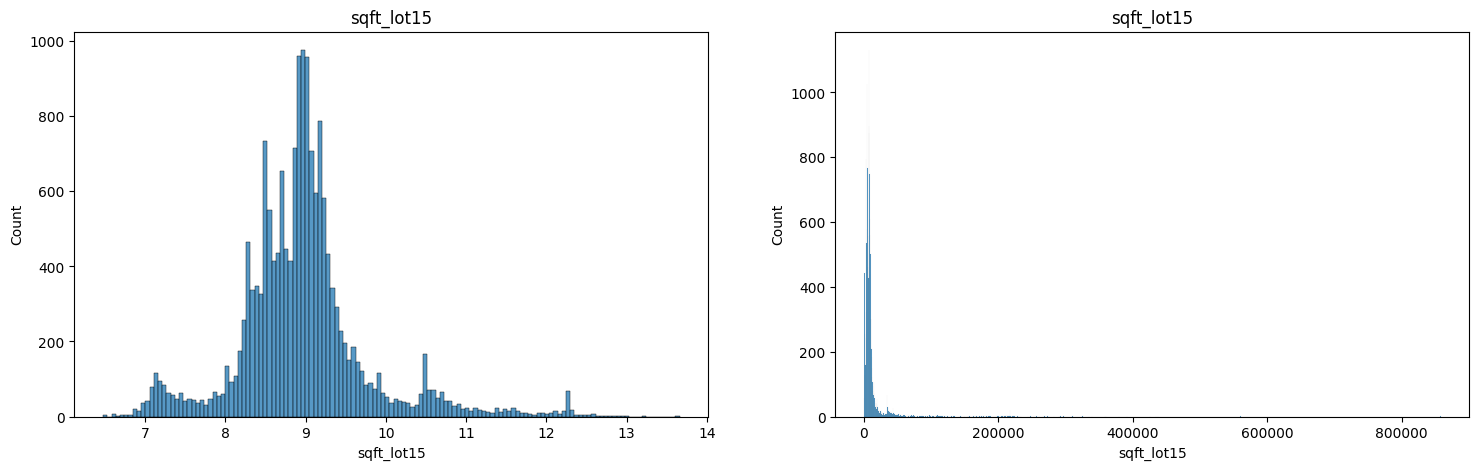

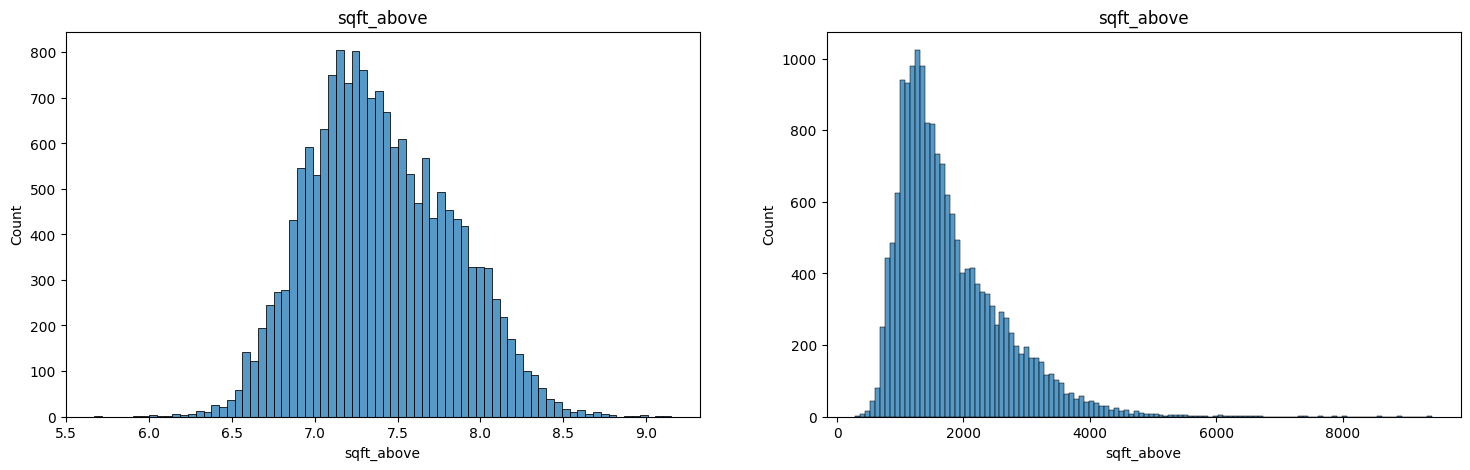

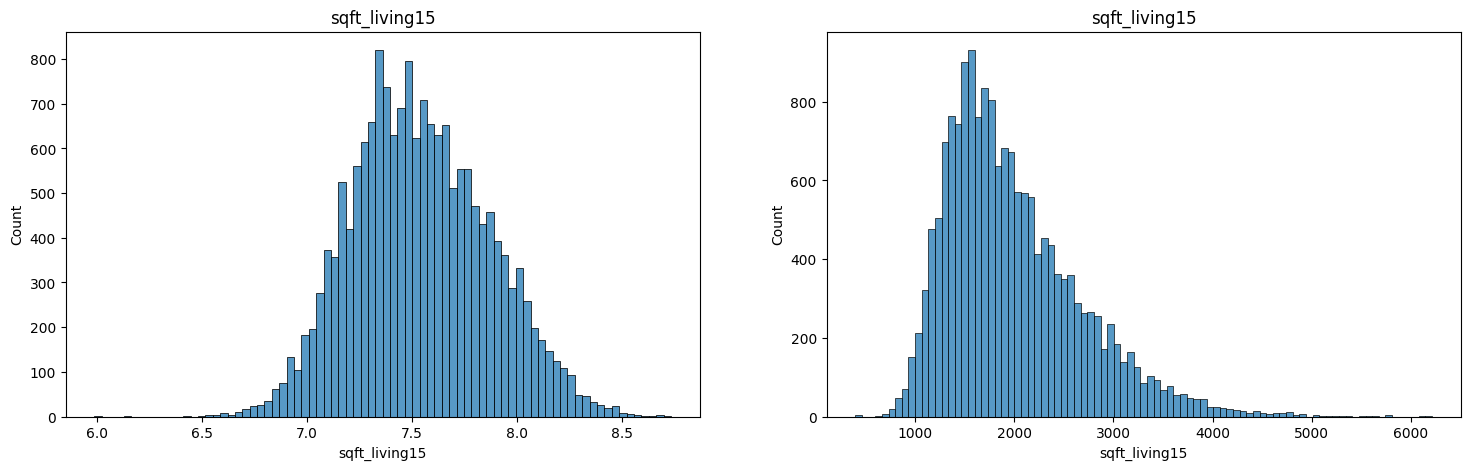

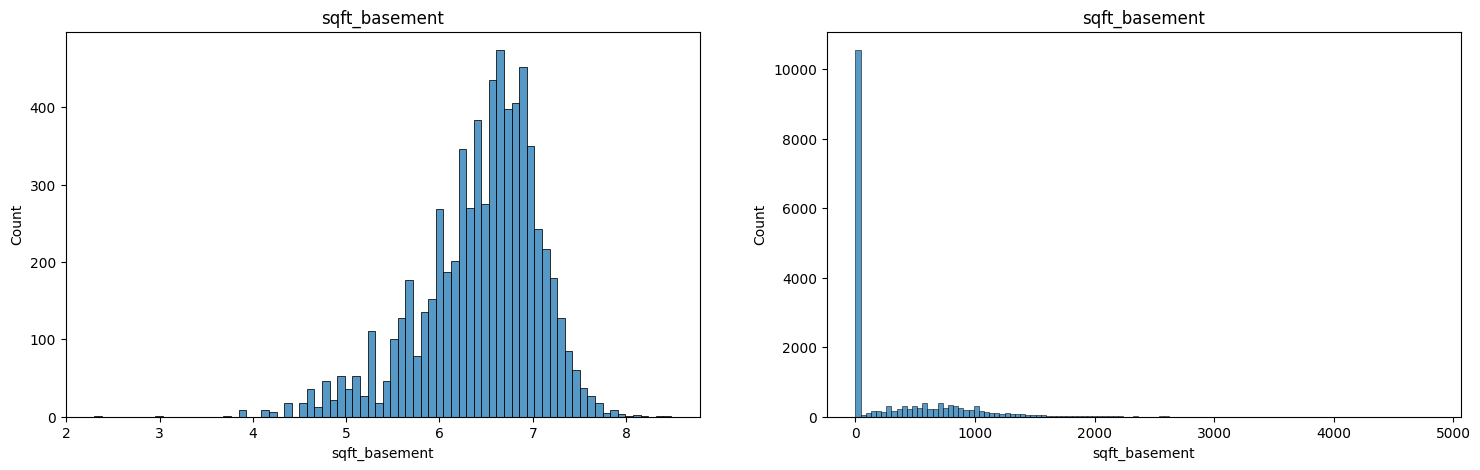

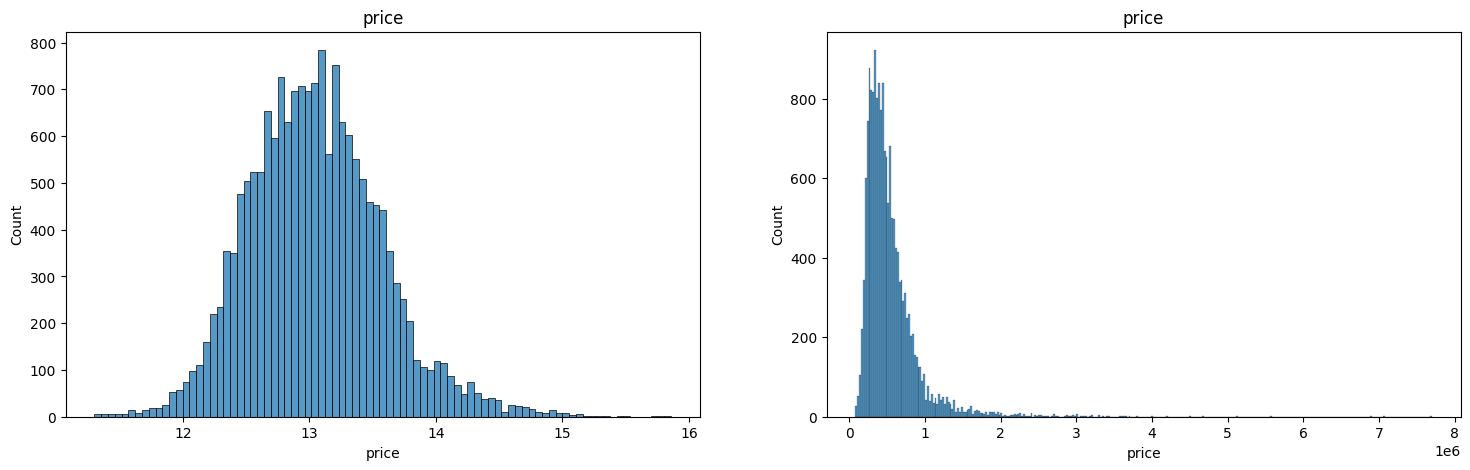

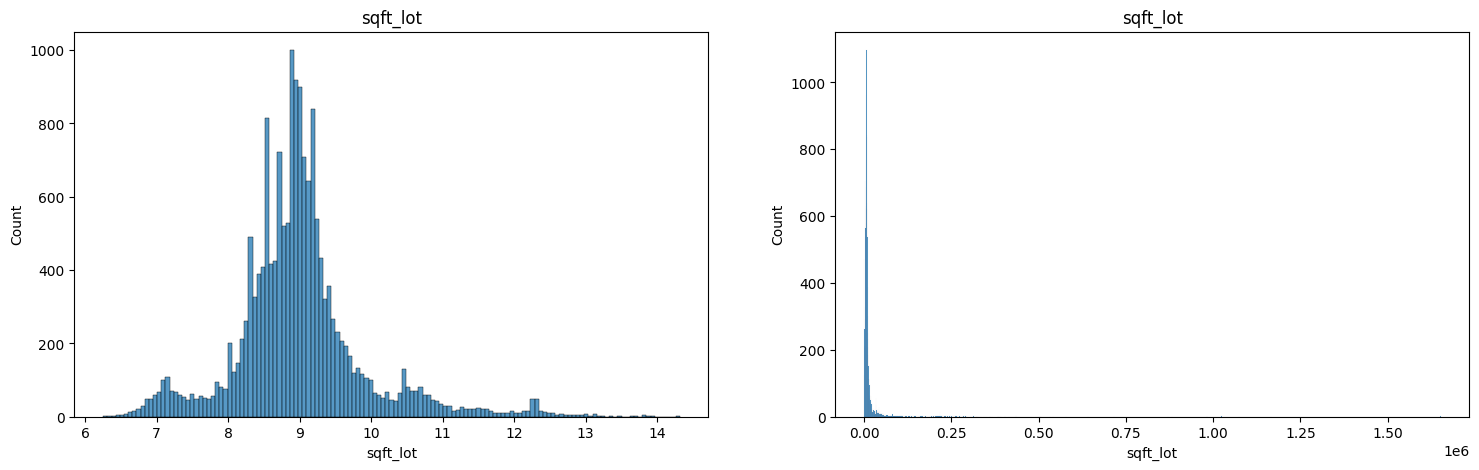

In [17]:
for f in features:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    sns.histplot(x=f, data=ln_train, ax=axes[0])
    sns.histplot(x=f, data=train, ax=axes[1])
    axes[0].set_title(f)
    axes[1].set_title(f)
    plt.show()

### Ой... \[2\]

Самый внимательные (или самые душные) ударили себя рукой по голове и правильно сделали. Если вы не понимаете почему, то присмотритесь к `sqft_basement`. Если всё ещё не понимаете, смотрите на исходные данные. Если снова не помогло, то посмотрите каких у нас значений больше всего: нулевых. А что это значит? Ну вот как посчитаете натуральный логарифм от нуля, так и скажите что это значит, а нам нужно этот косяк убрать. Есть разные способы, сейчас воспольземся одним из них. 

In [56]:
# узнайте, что делает функция log1p
ln_train['sqft_basement'] = np.log1p(train['sqft_basement'])

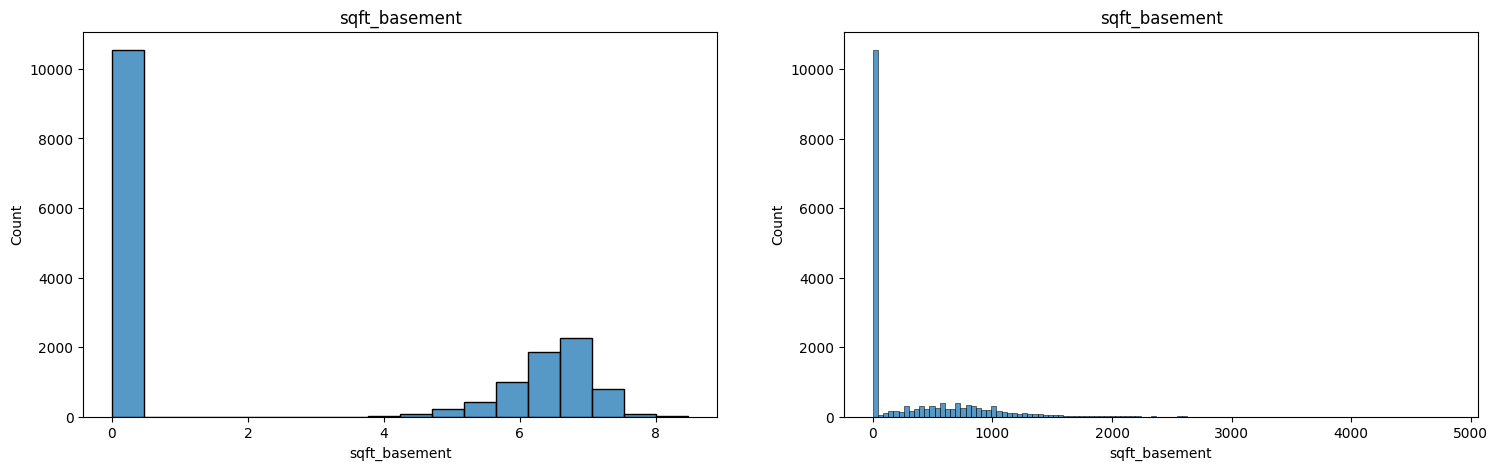

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.histplot(x='sqft_basement', data=ln_train, ax=axes[0])
sns.histplot(x='sqft_basement', data=train, ax=axes[1])
axes[0].set_title('sqft_basement')
axes[1].set_title('sqft_basement')
plt.show()

Самый умные уже заметили, что второй вариант действий, но мы пока остановимся на этом. 

### Попытка после логарифмирования

#### Разделение



In [ ]:
X_ln_t_train, X_ln_t_val, y_ln_t_train, y_ln_t_val = \
    our_split(ln_train, features)

# сразу восстанавливаем, чтобы потом не забыть
y_ln_t_val = np.exp(y_ln_t_val)

#### Масштабирование

In [59]:
scaler = StandardScaler()
# Функция fit_transform выполняет масштабирование и, что важно, 
# запоминает как какой столбец изменился
X_ln_t_train = scaler.fit_transform(X_ln_t_train)

# Делаем обратно датафреймом
X_ln_t_train = pd.DataFrame(X_ln_t_train, 
                              columns=list(set(features)-{'price'})) \
                .reset_index(drop=True) # убираем индексы

# Функция transform применяет масштабирование так, как она 
# промасштабировала обучающую выборку
X_ln_t_val = scaler.transform(X_ln_t_val)

# Делать тест снова датафреймом необязательно

#### Обучение

In [60]:
model = LinearRegression() 
model.fit(X_ln_t_train, y_ln_t_train) 
pass

#### Проверка
Поскольку целевую переменную мы также логарифмировали нужно её восстановить для точного сравнения.

In [61]:
y_t_pred = np.exp(model.predict(X_ln_t_val)) 
rmse = np.sqrt(mean_squared_error(y_ln_t_val, y_t_pred))
r2 = r2_score(y_ln_t_val, y_t_pred)
print("\nОценка модели:")
print("RMSE:", rmse)
print("R²:", r2)


Оценка модели:
RMSE: 267642.65978018526
R²: 0.463206057670962


C:\Users\dansu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Вышло хуже. Не расстраиваемся. Так бывает, всё нормально. 



### Второй вариант действий

Второй вариант $\text{---}$ сделать бинарную (принимающую только два значения) фичу: есть подвал или его нет.

#### Модификация

In [ ]:
# копируем нужные нам фичи
ln_train = train[features].copy()
# не логарифмируем площадь подвала
features_to_ln = list(set(features) - {'sqft_basement'})
ln_train = ln_df(ln_train, features_to_ln)

C:\Users\dansu\AppData\Local\Temp\ipykernel_5268\3843547829.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4.94164242 6.44571982 5.45958551 ... 6.76849321 6.63331843 6.08677473]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ln_train.loc[mask] = ln_df(ln_train.loc[mask], ['sqft_basement'])


In [102]:
# функция для добавления признака наличия подвала
def add_has_basement(df, inplace=False):
    # замещаем или нет исходный датафрейм
    res = df if inplace else df.copy()
    
    # создаём маску, которая выбирает только те строки, где есть подвал
    mask = res['sqft_basement'] > 0
    # бул переводим в инт: 1 -- есть подвал, 0 -- нет
    res['has_basement'] = mask.astype(int)

    return res

In [ ]:
add_has_basement(ln_train, True)
# Добавляем фичу в список используемых фич
features.append('has_basement')
# логарифмируем площадь подвалов в строках с подвалом

mask = ln_train['has_basement'] == 1
ln_train.loc[mask] = ln_df(ln_train.loc[mask], ['sqft_basement'])

#### Разделение

In [ ]:
X_ln_t_train, X_ln_t_val, y_ln_t_train, y_ln_t_val = \
    our_split(ln_train, features)

y_ln_t_val = np.exp(y_ln_t_val)

#### Масштабирование

Вот масштабирование сейчас будет несколько сложнее, потому что нам нужно отдельно отмасштабировать все признаки, кроме нашей бинарной переменной и площади подвала, поскольку если масштабировать его не отдельно, то нули сделают большой перекос, чего нам не надо.

In [90]:
scaler = StandardScaler()
basement_scaler = StandardScaler()

scale_features = list[set(features_to_ln) - {'price', 'has_basement'}]
X_ln_t_train[scale_features] \
    = scaler.fit_transform(X_ln_t_train[scale_features])

# создаём маску
mask = X_ln_t_train['sqft_basement'] > 0
# выбираем строки которые нужно проскейлить
sqft_basement_to_scale \
    = X_ln_t_train.loc[mask, 'sqft_basement'].values.reshape(-1, 1)
# скейлим
X_ln_t_train.loc[mask, 'sqft_basement'] \
    = basement_scaler.fit_transform(sqft_basement_to_scale).flatten()

# Тоже самое делаем с валидационным сетом
X_ln_t_val[scale_features] \
    = scaler.transform(X_ln_t_val[scale_features])

mask = X_ln_t_val['sqft_basement'] > 0
sqft_basement_to_scale \
    = X_ln_t_val.loc[mask, 'sqft_basement'].values.reshape(-1, 1)

X_ln_t_val.loc[mask, 'sqft_basement'] \
    = basement_scaler.transform(sqft_basement_to_scale).flatten()

#### Обучение

In [91]:
model = LinearRegression() 
model.fit(X_ln_t_train, y_ln_t_train) 
pass

#### Проверка

In [92]:
y_t_pred = np.exp(model.predict(X_ln_t_val)) 
rmse = np.sqrt(mean_squared_error(y_ln_t_val, y_t_pred))
r2 = r2_score(y_ln_t_val, y_t_pred)
print("\nОценка модели:")
print("RMSE:", rmse)
print("R²:", r2)


Оценка модели:
RMSE: 266322.4374963595
R²: 0.46848876877416035


Как видим, ситуация стала несколько лучше. Ещё раз, МО $\text{---}$ чуть меньше, чем полностью возня с данными, как говорится, не цель, а путь. 

Где мы могли допустить ошибку в текущей модели? Возможно, мы зря логарифмировали цену, ведь у нас довольно большой разброс данных, а после логарифмирования разница между $2$млн и $3$млн станет не такой большой и это может повлиять на точность предсказания дорогих объектов (а вместе с тем и большая среднеквадратичная ошибка). Проверим? Проверим.

In [71]:
y_ln_t_train = np.exp(y_ln_t_train)

In [72]:
model = LinearRegression() 
model.fit(X_ln_t_train, y_ln_t_train) 
pass

In [73]:
y_t_pred = model.predict(X_ln_t_val)
rmse = np.sqrt(mean_squared_error(y_ln_t_val, y_t_pred))
r2 = r2_score(y_ln_t_val, y_t_pred)
print("\nОценка модели:")
print("RMSE:", rmse)
print("R²:", r2)


Оценка модели:
RMSE: 276662.6636692396
R²: 0.42641466407083095


И это предположение оказалось неверным. Самое время сделать промежуточный вывод и идти дальше.

**Промежуточный вывод**: 
* Непрерывных признаков недостаточно для составления опорной модели.
* Эмпирические правила не всегда работают (поэтому не стоит слепо им доверять).
* Возможно, стоит отказаться от логарифмирования признаков или попробовать другие функции, сокращающие правый хвост.

Почему возможно? Потому что не понятно как это может отразиться в более сложной модели. Предлагаем расследовать это дело вам самим, а мы продолжим гнуть свою линию просто потому что можем (потому что для лучшего понимания необходимо делать что-то самому, а анализ без преобразований, очевидно, легче анализа с преобразованиями, поэтому мы продолжим делать его, а вы должны сравнивать результаты изменения нашей модели (логарифмированной) с результатами вашей (нелогарифмированной или, если хотите быть ещё круче, использующую другую функцию для того, чтобы убрать правые хвосты); это касается как последующих моделей, так и текущей, где мы выделили новый бинарный признак).

## Добавляем дискретные признаки

К дискретным признакам можно отнести: `bedrooms`, `floors` и `bathrooms`. Мы помним о `waterfront`, `view`, `condition` и `grade`, но пока оставим их.

К этим трём признакам можно относится как и обычным численным, так и как к категориальным признакам (хотя по поводу `bathrooms` совсем не уверены из-за необычности имеющихся данных, поэтому к ней будет относится исключительно как к численному признаку; но никто не запрещает вам испытать модель, где количество ванных комнат $\text{---}$ категориальный признак).

### Модель 2.1
#### Определение признаков

In [111]:
features = list(set(train.columns) - {'date', 'waterfront', 'view',
                                      'condition', 'grade', 'yr_built',
                                      'yr_renovated'})
print(features)

['sqft_living15', 'floors', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_lot', 'price', 'sqft_basement', 'bedrooms']


#### Модификация

In [ ]:
# копируем нужные нам фичи
ln_train = train[features].copy()
# не логарифмируем площадь подвала
features_to_ln = ['sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_lot', 
                  'price']
ln_train = ln_df(ln_train, features_to_ln)

add_has_basement(ln_train, True)
# Добавляем фичу в список используемых фич
features.append('has_basement')

# логарифмируем площадь подвалов в строках с подвалом
mask = ln_train['has_basement'] == 1
ln_train.loc[mask] = ln_df(ln_train.loc[mask], ['sqft_basement'])

C:\Users\dansu\AppData\Local\Temp\ipykernel_5268\2232083768.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4.94164242 6.44571982 5.45958551 ... 6.76849321 6.63331843 6.08677473]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ln_train.loc[mask] = ln_df(ln_train.loc[mask], ['sqft_basement'])


#### Разделение

In [ ]:
X_ln_t_train, X_ln_t_val, y_ln_t_train, y_ln_t_val = \
    our_split(ln_train, features)

y_ln_t_val = np.exp(y_ln_t_val)

#### Масштабирование

In [115]:
scaler = StandardScaler()
basement_scaler = StandardScaler()

scale_features = list[set(features) - {'price', 'has_basement'}]
X_ln_t_train[scale_features] \
    = scaler.fit_transform(X_ln_t_train[scale_features])

# создаём маску
mask = X_ln_t_train['sqft_basement'] > 0
# выбираем строки которые нужно проскейлить
sqft_basement_to_scale \
    = X_ln_t_train.loc[mask, 'sqft_basement'].values.reshape(-1, 1)
# скейлим
X_ln_t_train.loc[mask, 'sqft_basement'] \
    = basement_scaler.fit_transform(sqft_basement_to_scale).flatten()

# Тоже самое делаем с валидационным сетом
X_ln_t_val[scale_features] \
    = scaler.transform(X_ln_t_val[scale_features])

mask = X_ln_t_val['sqft_basement'] > 0
sqft_basement_to_scale \
    = X_ln_t_val.loc[mask, 'sqft_basement'].values.reshape(-1, 1)

X_ln_t_val.loc[mask, 'sqft_basement'] \
    = basement_scaler.transform(sqft_basement_to_scale).flatten()

#### Обучение, результаты

In [116]:
model = LinearRegression() 
model.fit(X_ln_t_train, y_ln_t_train)

y_t_pred = np.exp(model.predict(X_ln_t_val)) 
rmse = np.sqrt(mean_squared_error(y_ln_t_val, y_t_pred))
r2 = r2_score(y_ln_t_val, y_t_pred)
print("\nОценка модели:")
print("RMSE:", rmse)
print("R²:", r2)


Оценка модели:
RMSE: 264080.7823285669
R²: 0.47739864949148203


Отлично, добавление новых признаков немногим улучшило нашу модель (не так значительно, чтобы это в действительности отмечать, но $2000$ баксов, это $2000$ баксов; и всё ещё напоминаю, что у нас учебный пример).

А теперь вспоминаем, что мы наблюдали на [графиках](#дискретные-переменные) и то, что мы хотели фильтрануть выбросы.

***